# 주식 종가 예측
- [Kaggle] [Optiver - Trading at the Close](https://www.kaggle.com/competitions/optiver-trading-at-the-close)  
- Predict US stocks closing movements / 미국 증시 마감 움직임 예측  
    - 나스닥 증권 거래소에서의 매일 10분간의 마감 경매에 대한 데이터.
    - 나스닥 상장 주식으로 구성된 종합 지수의 미래 가격 움직임을 보고, 주식의 미래 가격을 예측하는 과제.  
- 2023-11 참가
- 메모
  - https://www.kaggle.com/code/zulqarnainali/lgb-fine-tuned-explained
  - https://www.kaggle.com/code/monkeyjeong/baseline-lgb-xgb-and-catboost
  - https://www.kaggle.com/code/ravi20076/optiver-baseline-models

In [1]:
# import
import pandas as pd
import numpy as np


# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import os
os.getcwd()

'/content'

# 1. 데이터 준비

In [16]:
df_origin = df = pd.read_csv('/content/drive/MyDrive/datasets/optiver-trading-at-the-close/train.csv')

## 1) 데이터 유형 확인
- 관측치 약 523만 개, 컬럼 17개  
- 1개 컬럼만 object, 나머지는 전부 숫자형(int, float)

| 컬럼명 | 설명 | 컬럼명 | 설명 |
| :-: | --- | :-: | --- |
|stock_id | 주식 식별자| far_price| (경매) 원격 가격
|date_id|날짜 식별자|near_price|근접 가격|
|seconds_in_bucket|경매 경과 시간 (단위: 초)|bid_price/ask_price|비경매에서 가장 경쟁력 있는 매도/매입 가격|
|imbalance_buy_sell_flag|구매측 불균형: 1, 판매측 불균형: -1, 균형: 0|bid_size/ ask_size|위 가격을 달러로 표기|
|imbalance_size|현재 준거가격(reference_price)과 불일치하는 매수/매도 불균형 액수|reference_price|준거가격|
|wap|비경매 장부의 가중 평균 가격(Weighted Avg Price). 주식장이 열린 시간동안(즉, 비경매) 가격에 주식량을 가중한 수치. |
|target|60초 이후 가격 예측(train set에만 제공됨)|matched_size|현재 준거가격과 일치되는 금액|
|time_id|-|row_id|-|


In [3]:
# 기본 정보
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


- 데이터 미리보기

In [13]:
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


- 상관관계 확인

<ipython-input-4-8eb578702eca>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
<ipython-input-4-8eb578702eca>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool)) # 대각선 아래만


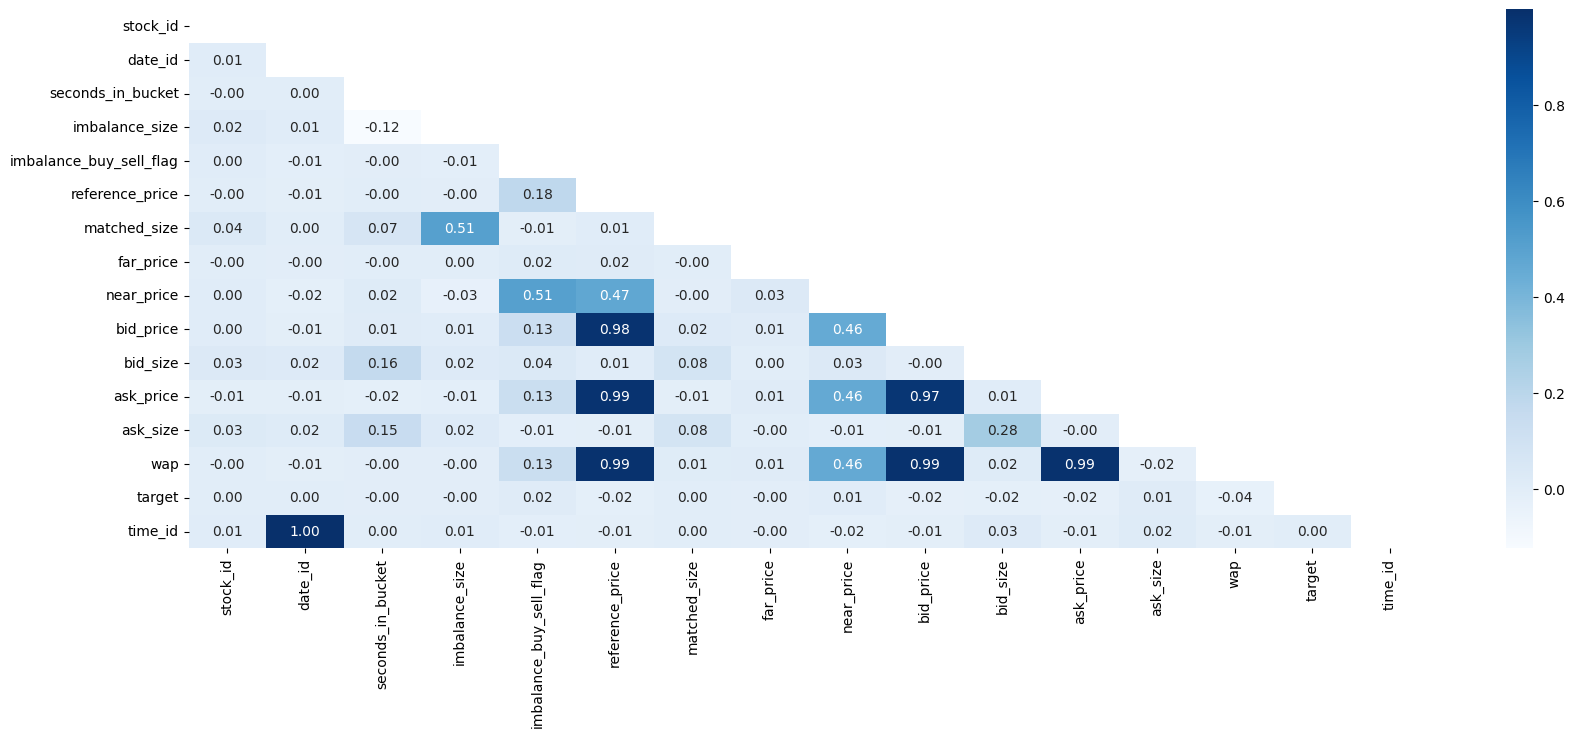

In [4]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool)) # 대각선 아래만
plt.figure(figsize=(20, 7))
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', mask=mask)
plt.show()

상관관계 있는 피처
- near_price, reference price, bid_price, ask_price, wap, reference_price
- imbalance_sice, matched_size
- near_price, imbalance_buy_sell_flag

위의 피처를 포함한 10개 피처 사용

In [36]:
# 사용할 피처
features = ['seconds_in_bucket', 'imbalance_buy_sell_flag',
            'imbalance_size', 'matched_size',
            'bid_size', 'ask_size',
            'reference_price','far_price',
            'near_price', 'ask_price',
            'bid_price', 'wap']

## 2) 데이터 클린징
결측치, 이상치, 중복치 등 처리

- 결측치 확인
  - target 결측치 88개: **학습 불가하여 제외해야됨**
  - imbalance_size, reference_price, matched_size, bid_price, ask_price, wap: 약 220개 결측치 (+ 결측값 갖는 행 서로 겹침)
  - far_price, near_price: 약 285만개 결측치. 전체 관측치의 절반에 해당 -> **평균치로 대체?**

In [17]:
df.isnull().sum()   # 결측값 확인

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

- 220개 결측값 제거 -> - target 결측값인 행도 같이 제거됨

In [19]:
#df[df[['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price', 'wap']].isnull()]
df[ df['imbalance_size'].isnull() & df['reference_price'].isnull() & df['matched_size'].isnull() & df['bid_price'].isnull() & df['ask_price'].isnull()  & df['wap'].isnull()]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
369508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4775199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4775399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4775599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df = df.dropna(subset=['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price', 'wap'])
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                   0
imbalance_buy_sell_flag          0
reference_price                  0
matched_size                     0
far_price                  2894122
near_price                 2856960
bid_price                        0
bid_size                         0
ask_price                        0
ask_size                         0
wap                              0
target                           0
time_id                          0
row_id                           0
dtype: int64

## 3) 파생 변수

# 2. Model Training


- 참고: Boosting이란 여러 개의 약한 Decision Tree를 조합해서 사용하는 앙상블 기법 중 하나
- 인기있는 baseline  
  1) **XGBoost** (Extreme Gradient Boosting)  
  - Boosting 기법 기반의 알고리즘인 Gradient Boost를 병렬학습 지원하도록 한 라이브러리
  - GBM 대비 빠른 시간
  - 과적합 규제에 뛰어남

  2) **LightGBM** (Light Gradient Boosting Machine)
  - 장점: Light, 메모리를 적게 차지하고 속도가 빠르면서 정확도가 높다.
  - 특징: 범주형 변수를 숫자형으로 바꾸지 않고 학습시킴
  - 단점: overfitting에 민감함. 데이터 개수가 10,000개 이상일 때 좋음
  - 메모: 과적합 줄이는 방법들 인터넷에 공유되어 있음.

  3) CatBoost
  - 데이터셋이 대부분 범주형 변수일 때 성능 우수


In [40]:
df_train = df

In [51]:
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF,
                                     StratifiedKFold as SKF,
                                     KFold,
                                     RepeatedKFold as RKF,
                                     cross_val_score);

from lightgbm import log_evaluation, early_stopping, LGBMRegressor as lgb;
from xgboost import XGBRegressor as xgb;
# from catboost import CatBoostRegressor as CBR;
from sklearn.ensemble import HistGradientBoostingRegressor as HGBR;
from sklearn.metrics import mean_absolute_error as mae, make_scorer;

# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cbt
import joblib

In [52]:
modelname = 'lgb'   # lgb, xgb
TRAINING = True
N_fold = 5
model_path = '/content/drive/MyDrive/models'

In [58]:
def train(i, index, model_dict, modelname='lgb'):
    if TRAINING:
        model = model_dict[modelname]
        model.fit(X[index % N_fold != i], Y[index % N_fold != i],
                    eval_set=[(X[index % N_fold==i], Y[index % N_fold==i])],
                    # verbose=10,
                    #early_stopping_rounds=50
                    )
        models.append(model)
        joblib.dump(model, f'{model_path}/{modelname}_{i}.model')
    else:
        models.append(joblib.load(f'{model_path}/{modelname}_{i}.model'))
    return

In [59]:
if TRAINING:
    X = df[features].values
    Y = df['target'].values

    # Y가 유효한 행만 사용
    X = X[np.isfinite(Y)]
    Y = Y[np.isfinite(Y)]

    index = np.arange(len(X))

models = []

model_dict = {
    'lgb': lgb(objective='regression_l1', n_estimators=500),
    'xgb': xgb(tree_method='hist', objective='reg:absoluteerror', n_estimators=500),
    #'cbt': cbt.CatBoostRegressor(objective='MAE', iterations=3000),
}

for i in range(N_fold):
    train(i, index, model_dict, modelname)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.743725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2608
[LightGBM] [Info] Number of data points in the train set: 4190208, number of used features: 12
[LightGBM] [Info] Start training from score -0.060201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.260770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2608
[LightGBM] [Info] Number of data points in the train set: 4190208, number of used features: 12
[LightGBM] [Info] Start training from score -0.060201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

In [ ]:
test_path = '/content/drive/MyDrive/datasets/optiver-trading-at-the-close/optiver2023'
iter_test = env.iter_test()

counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    feat = generate_features(test)

    sample_prediction['target'] = np.mean([model.predict(feat) for model in models], 0)
    env.predict(sample_prediction)
    counter += 1